# Image Processing

The goal of this notebook is to take the 10000 images I web scraped from grailed.com and extract their color palettes.

## Importing Libraries

In [33]:
import numpy as np
import cv2 as cv
from colorthief import ColorThief
import os
import matplotlib.pyplot as plt 
import pandas as pd
import sys

In [ ]:
sys.path.append('./src/modules/')

import image_process as ip

In [2]:
def plot_color_palette(img_path):
    '''Takes in a file path, uses the ColorThief library to pull the 4 most dominant colors and
       displays the image along with its palette.'''
    # Load the image- cv2 uses bgr color encoding so it needs to be converted to rgb for matplotlib
    image_vec = cv.imread(img_path, 1)
    RGB_img = cv.cvtColor(image_vec, cv.COLOR_BGR2RGB)

    # Pull the color palette
    color_thief = ColorThief(img_path)
    color_palette = color_thief.get_palette(quality = 1, color_count=3)

    # Reformat the color array for easy plotting
    palette = np.array(color_palette)[np.newaxis, :, :]

    # Create a plot of the image and its palette
    fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,6))

    ax1.imshow(RGB_img);
    ax1.set_title('Original Image');
    ax2.imshow(palette);
    ax2.axis('off');
    ax2.set_title('Color Palette');
    plt.show();

## Plotting the first sample image

As an exploration I used Colorthief on some of my images to see how well it did by plotting the palette that was generated next to the image.

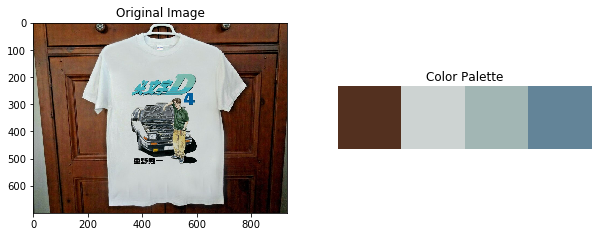

In [3]:
ip.plot_color_palette('./images/127.jpg')

The most dominant color in this (and many other images) is the background it was photographed on. To prevent recommending clothes that are simply on top of a color in the user's chosen palette I'll need to isolate the subject of the image.

In [4]:
def remove_background(rgb_img):
    '''This code block is adapted from Chris Albon
       https://chrisalbon.com/machine_learning/preprocessing_images/remove_backgrounds/
       Given an RBG image ~700x700, creates a rectangle in the center of the frame, 
       analyzes the area outside the frame, and using cv2 GrabCut, subtracts everything 
       inside that looks like the outside'''
    
    # Create initial mask
    mask = np.zeros(rgb_img.shape[:2], np.uint8)

    # Create temporary arrays used by grabCut
    bgdModel = np.zeros((1, 65), np.float64)
    fgdModel = np.zeros((1, 65), np.float64)

    # Creating a rectangle to select the center of the image
    rectangle = (80, 40, 600, 600)

    # Run grabCut
    cv.grabCut(rgb_img, # Our image
            mask, # The Mask
            rectangle, # Our rectangle
            bgdModel, # Temporary array for background
            fgdModel, # Temporary array for background
            5, # Number of iterations
            cv.GC_INIT_WITH_RECT) # Initiative using our rectangle

    # Create mask where sure and likely backgrounds set to 0, otherwise 1
    mask_2 = np.where((mask==2) | (mask==0), 0, 1).astype('uint8')

    # Multiply image with new mask to subtract background
    image_rgb_nobg = rgb_img * mask_2[:, :, np.newaxis]
    return image_rgb_nobg

## Removing backgrounds

In [5]:
# Load the same image as above
image_vec = cv.imread('./images/127.jpg', 1)

# Convert from BGR to RGB as cv2 imports BGR as a default
RGB_img = cv.cvtColor(image_vec, cv.COLOR_BGR2RGB)

# Testing the remove_background function
new_img = ip.remove_background(RGB_img)

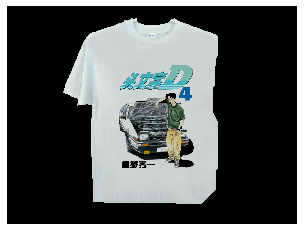

In [6]:
# Display the image after removing background
plt.imshow(new_img), plt.axis("off")
plt.show()

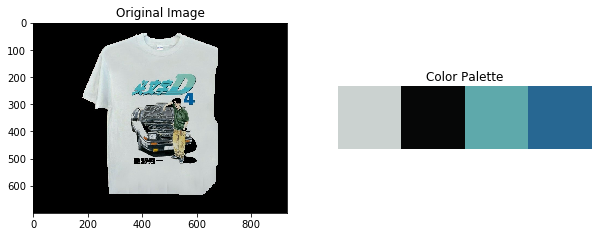

In [24]:
# The dominant value is now black for the most part, which should be easy to discard from my color arrays 

ip.plot_color_palette('./test/127.jpg')

Perfect! I've lost a little bit of the image, but I can still pull the data I need from it. There's a lot of black in the image now which is easy to remove. Some of the images are more reduced than others but overall this function seems very effective.

In [8]:
def convert_images(source_directory, destination_directory):
    '''Given source and destination directories, takes images ~700x700 and removes the background
       replacing it with black. The new image is then saved in the destination directory. This function
       outputs a count after every 50 photos'''
    # Iterate through all files in the directory
    for i, filename in enumerate(os.listdir(source_directory)):
        
        # Select only jpegs
        if filename.endswith(".jpg"):
            
            # Load the image
            image = cv.imread(f'{source_directory}{filename}', 1)
            # Convert to RBG
            # RGB_img = cv.cvtColor(image, cv.COLOR_BGR2RGB)
            # Remove the background
            new_img = remove_background(RGB_img)
            # Save the image
            cv.imwrite(f'{destination_directory}{filename}', new_img)
            # Progress counter
            if i%50 == 0:
                print(f'{i} Images Converted')
    return print('All Images Converted')

In [182]:
# Remove backgrounds from all 10000 images and save

ip.convert_images('./images/', './dummy/')

0 Images Converted
50 Images Converted
100 Images Converted
150 Images Converted
200 Images Converted
250 Images Converted
300 Images Converted
350 Images Converted
400 Images Converted
450 Images Converted
500 Images Converted
550 Images Converted
600 Images Converted
650 Images Converted
700 Images Converted
750 Images Converted
800 Images Converted
850 Images Converted
900 Images Converted
950 Images Converted
1000 Images Converted
1050 Images Converted
1100 Images Converted
1150 Images Converted
1200 Images Converted
1250 Images Converted
1300 Images Converted
1350 Images Converted
1400 Images Converted
1450 Images Converted
1500 Images Converted
1550 Images Converted
1600 Images Converted
1650 Images Converted
1700 Images Converted
1750 Images Converted
1800 Images Converted
1850 Images Converted
1900 Images Converted
1950 Images Converted
2000 Images Converted
2050 Images Converted
2100 Images Converted
2150 Images Converted
2200 Images Converted
2250 Images Converted
2300 Images

In [17]:
def convert_directory_to_rgb(source_file_path, dest_file_path):
    for filename in os.listdir(source_file_path):
        if filename.endswith('.jpg'):
            img = cv.imread(f'{source_file_path}{filename}')
            RGB_img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
            cv.imwrite(f'{dest_file_path}{filename}', RGB_img)
    return print('Color correction complete')

In [19]:
#Perform a color correction on the new directory

ip.convert_directory_to_rgb('./dummy/', './test/')

Color correction complete


## Testing the Results

Having removed the backgrounds, I chose a few sample images to pull color palettes from. 

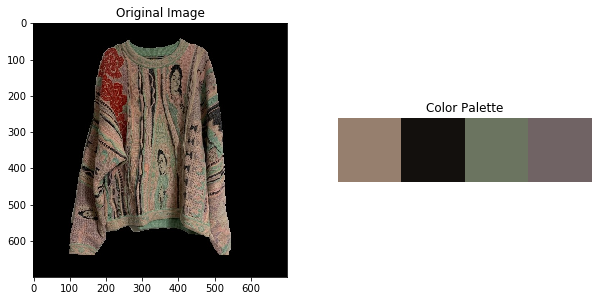

In [28]:
plot_color_palette('./converted_images/125.jpg')

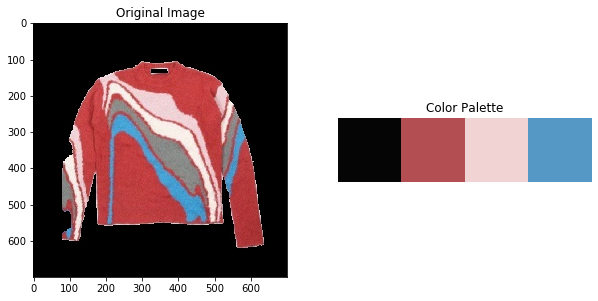

In [30]:
plot_color_palette('./converted_images/4363.jpg')

In [ ]:
Looks good! Now to condense the palettes into a DataFrame.

In [50]:
def color_palette_dataframe(filepath):
    '''Pulls the 3 most dominant colors in an image palette and returns of DataFrame
       with the filename as index and the RGB values as columns'''
    # Create an empty dictionary
    color_dict = {}

    # Iterate through all files in the chosen directory
    for i, filename in enumerate(os.listdir(filepath)):
        
        # Filter out any non-image files
        if filename.endswith('.jpg'):
            
            # Instantiate ColorThief and get the color palette
            color_thief = ColorThief(f'{filepath}{filename}')
            color_palette = color_thief.get_palette(quality = 1, color_count=3)
            
            # Create a new list of the sums of each RGB tuple
            new_list = [sum(i) for i in color_palette]
            
            # Remove the lowest RGB value from the list- this will be the black in the background of each image
            # and add the remaining values to the dictionary with the image number as index
            color_dict.update({filename.strip('.jpg') : [i for i in color_palette if sum(i) != min(new_list)]})
            
            # Progress counter
            if i%100 == 0:
                print(f'{i} files complete')
    
    # Convert the dictionary to a dataframe with the filename as index
    return pd.DataFrame.from_dict(color_dict, orient = 'index')

In [51]:
# Generating a DataFrame of the image name and 3 most dominant colors, excluding black

colordf = ip.color_palette_dataframe('./converted_images/')

0 files complete
100 files complete
200 files complete
300 files complete
400 files complete
500 files complete
600 files complete
700 files complete
800 files complete
900 files complete
1000 files complete
1100 files complete
1200 files complete
1300 files complete
1400 files complete
1500 files complete
1600 files complete
1700 files complete
1800 files complete
1900 files complete
2000 files complete
2100 files complete
2200 files complete
2300 files complete
2400 files complete
2500 files complete
2600 files complete
2700 files complete
2800 files complete
2900 files complete
3000 files complete
3100 files complete
3200 files complete
3300 files complete
3400 files complete
3500 files complete
3600 files complete
3700 files complete
3800 files complete
3900 files complete
4000 files complete
4100 files complete
4200 files complete
4300 files complete
4400 files complete
4500 files complete
4600 files complete
4700 files complete
4800 files complete
4900 files complete
5000 files c

In [52]:
colordf.head()

,0,1,2
9733,"(176, 146, 125)","(120, 132, 107)","(124, 124, 132)"
63,"(223, 219, 217)","(115, 139, 127)","(117, 118, 135)"
6400,"(194, 103, 102)","(143, 136, 127)","(140, 124, 132)"
823,"(233, 234, 234)","(109, 152, 108)","(106, 122, 108)"
4217,"(208, 195, 181)","(124, 124, 117)","(122, 116, 124)"


In [53]:
# Saving the new DataFrame to csv

colordf.to_csv('./data/colors.csv')